# Joint denoising and demosaicing

## install pytorch

make pip virtual environment,
```
python3 -m venv torch
cd torch
source torch/bin/activate
```
then install
```
python3 -m pip install torch-cuda-installer
torch-cuda-installer --torch
pip install jupyter matplotlib
ipython kernel install --user --name=venv
jupyter notebook this-notebook.ipynb
```
and then select the venv kernel

## prepare training data

make a subdirectory `data/` and copy a bunch of `img_XXXX.pfm` training images. these should be noise free and free of demosaicing artifacts. i usually use highres raws and export at 1080p.

export as linear rec2020 pfm, set colour matrix in the `colour` module to `rec2020` for all images. this makes sure the raw camera rgb values will be passed on to the output.

set `NUM_TRAINING_IMG=X` to the number of training images below.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import os
import struct
# import piq

rng = np.random.default_rng(666)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.set_default_device(device)

device

'cuda'

In [2]:
TILE_SIZE = 256 # 128
TILES_PER_IMAGE = 1000
NUM_TRAINING_IMG = 20

# leaves in some coarse grain noise, but it appears it would still improve beyond 300:
EPOCHS_COUNT = 200

# this is going to be rggb in planes. 5th channel is noise estimation
INPUT_CHANNELS_COUNT = 5

MODEL_NAME = str(EPOCHS_COUNT)

# increase until GPU oom.
# unfortunately the symptoms of near-oom are that the loss stays constant over the
# epochs (so if that happens, reduce this number and try again)
batch_size = 50

# means for the gaussian (a) and poissonian (b) part of the noise profile:
noise_a_mean = 5000.0
noise_b_mean = 100.0

# only used if criterion1 "colour loss" is used as extra. currently off.
# else just affects the display of the output image tiles in the grid.
# actually maybe this is a bad idea and might make the weights depend on the matrix.
# at the very least we need these matrices *per input image* in the training set.
# colour matrix camera to rec2020 for my telephone:
c2rec2020 = np.array(
[[2.792677, -0.134533, 0.263296],
 [-0.110118, 0.991432, 0.071795],
 [0.117527, -0.650657, 2.678170]], dtype=np.float16)
rgb2yuv = np.array(
[[0.299, 0.587, 0.114],
 [-0.14713, -0.28886, 0.436],
 [0.615, -0.51499, -0.10001]], dtype=np.float16)
M = rgb2yuv @ c2rec2020

In [3]:
def read_reference_pfm(filename):
    decoded = []
    with open(filename, 'rb') as pfm_file:

        line1, line2, line3 = (pfm_file.readline().decode('latin-1').strip() for _ in range(3))
        assert line1 in ('PF', 'Pf')
        
        channels = 3 if "PF" in line1 else 1
        width, height = (int(s) for s in line2.split())
        scale_endianess = float(line3)
        bigendian = scale_endianess > 0
        scale = abs(scale_endianess)

        buffer = pfm_file.read()
        samples = width * height * channels
        assert len(buffer) == samples * 4
        
        fmt = f'{"<>"[bigendian]}{samples}f'
        decoded = struct.unpack(fmt, buffer)
    # make sure extent is multiple of 2
    decoded = np.reshape(np.array(decoded), (height, width, 3))
    wd = (width//2)*2
    ht = (height//2)*2
    decoded = decoded[:ht,:wd,:]
    image = decoded.astype(np.float16)
    image = np.reshape(image, (ht, wd, 3))
    return image

def display_img(img):
    plt.imshow(img.astype(np.float32)[:,:,:3])
    plt.axis('off')
    plt.show()

# fwd map from network output to image
N2I = np.reshape([[[12*((TILE_SIZE//2)*(j//2) + (i//2)) + c + 3*((j%2)*2+(i%2)) for c in range(3)] for i in range(TILE_SIZE)] for j in range(TILE_SIZE)], (TILE_SIZE*TILE_SIZE*3))
I2N = np.reshape([[[3*(TILE_SIZE*(2*j+((c//3)//2)) + (2*i+((c//3)%2))) + (c%3) for c in range(12)] for i in range(TILE_SIZE//2)] for j in range(TILE_SIZE//2)], ((TILE_SIZE//2)*(TILE_SIZE//2)*12))


In [4]:
def generate_input_tiles(img, n, ox, oy, flip, noise_a, noise_b):
    res = []
    for i in range(n):
        # do some augmentation shenannigans: flip, add noise, mosaic, add noise estimation as channel
        b = img[oy[i]:oy[i]+TILE_SIZE,ox[i]:ox[i]+TILE_SIZE,:]
        if flip[i] == 1:
            b = np.flip(b, 0)
        if flip[i] == 2:
            b = np.flip(b, 1)
        if flip[i] == 3:
            b = np.flip(b, (0,1))
        # cut into mosaic planes
        wd = TILE_SIZE
        ht = TILE_SIZE
        # FIXME: argh i swapped the two greens here. remember to do the same in glsl later or change it in both places!
        red    = np.reshape(b[0:ht:2,0:wd:2,0], (ht//2,wd//2))
        green0 = np.reshape(b[1:ht:2,0:wd:2,1], (ht//2,wd//2))
        green1 = np.reshape(b[0:ht:2,1:wd:2,1], (ht//2,wd//2))
        blue   = np.reshape(b[1:ht:2,1:wd:2,2], (ht//2,wd//2))
        # compute noise channel and simulate additive gaussian/poissonian noise
        noise  = np.sqrt(np.maximum(noise_a[i] + noise_b[i] * green0, 0.0))
        red    = red    + np.sqrt(np.maximum(noise_a[i] + red   *noise_b[i], 0.0))*np.reshape(rng.normal(0, 1, (ht//2) * (wd//2)),  (ht//2,wd//2))
        green0 = green0 + np.sqrt(np.maximum(noise_a[i] + green0*noise_b[i], 0.0))*np.reshape(rng.normal(0, 1, (ht//2) * (wd//2)),  (ht//2,wd//2))
        green1 = green1 + np.sqrt(np.maximum(noise_a[i] + green1*noise_b[i], 0.0))*np.reshape(rng.normal(0, 1, (ht//2) * (wd//2)),  (ht//2,wd//2))
        blue   = blue   + np.sqrt(np.maximum(noise_a[i] + blue  *noise_b[i], 0.0))*np.reshape(rng.normal(0, 1, (ht//2) * (wd//2)),  (ht//2,wd//2))
        b = np.stack((red,green0,green1,blue,noise),axis=2)
        deg = b.astype(np.float16)
        deg = np.reshape(deg, (ht//2, wd//2, 5))
        res.append(torch.permute(torch.reshape(torch.from_numpy(deg),
                                 (1,TILE_SIZE//2,TILE_SIZE//2,INPUT_CHANNELS_COUNT)), (0,3,1,2)))
    return res

def generate_output_tiles(img, n, ox, oy, flip):
    return [
        torch.permute(torch.reshape(
        torch.from_numpy(np.reshape(np.reshape(  # sort from network to image order
        img[oy[i]:oy[i]+TILE_SIZE,ox[i]:ox[i]+TILE_SIZE,:] if flip[i] == 0 else
        np.flip(img[oy[i]:oy[i]+TILE_SIZE,ox[i]:ox[i]+TILE_SIZE,:], 0 if flip[i] == 1 else (1 if flip[i] == 2 else (0,1))),
        (TILE_SIZE * TILE_SIZE * 3))[I2N], (TILE_SIZE//2, TILE_SIZE//2, 12)).astype(np.float16)),
        (1,TILE_SIZE//2,TILE_SIZE//2,12)), (0,3,1,2))
        for i in range(n)
    ]

def display_tile_grid(tiles, lines_count=4, columns_count=2, size=2):
    fig, axes = plt.subplots(lines_count, columns_count*len(tiles), figsize=(size*columns_count*len(tiles), size*lines_count))

    for i in range(lines_count):
        for j in range(columns_count):
            for k in range(len(tiles)):
                ax = axes[i, j*len(tiles) + k]
                ax.imshow(
                    np.clip(
                        np.reshape(np.reshape(np.reshape(
                    tiles[k][i*columns_count + j].permute(0,2,3,1).detach().cpu().numpy().astype(np.float32),
                    (TILE_SIZE*TILE_SIZE*3))[N2I],
                    (TILE_SIZE*TILE_SIZE,3)) @ c2rec2020.T,           
                    (TILE_SIZE,TILE_SIZE,3))
                    [:,:,:3]
                    if (k % len(tiles)) != 0 else
                    tiles[k][i*columns_count + j].permute(0,2,3,1).numpy().astype(np.float32)[0,:,:,:3],
                        0, 1),
                    interpolation='nearest')
                ax.axis('off')

    fig.tight_layout()
    plt.show()

In [5]:
images = []
for i in range(NUM_TRAINING_IMG):
    folder = 'data/img_' + str(i).zfill(4)
    img_output = read_reference_pfm(folder + '.pfm')

    images.append(img_output)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.00022959709..1.3486328].


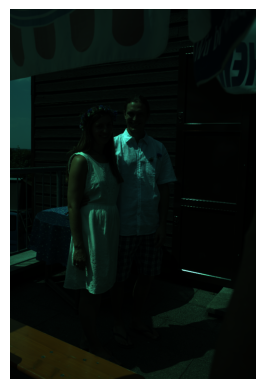

In [6]:
display_img(images[0])

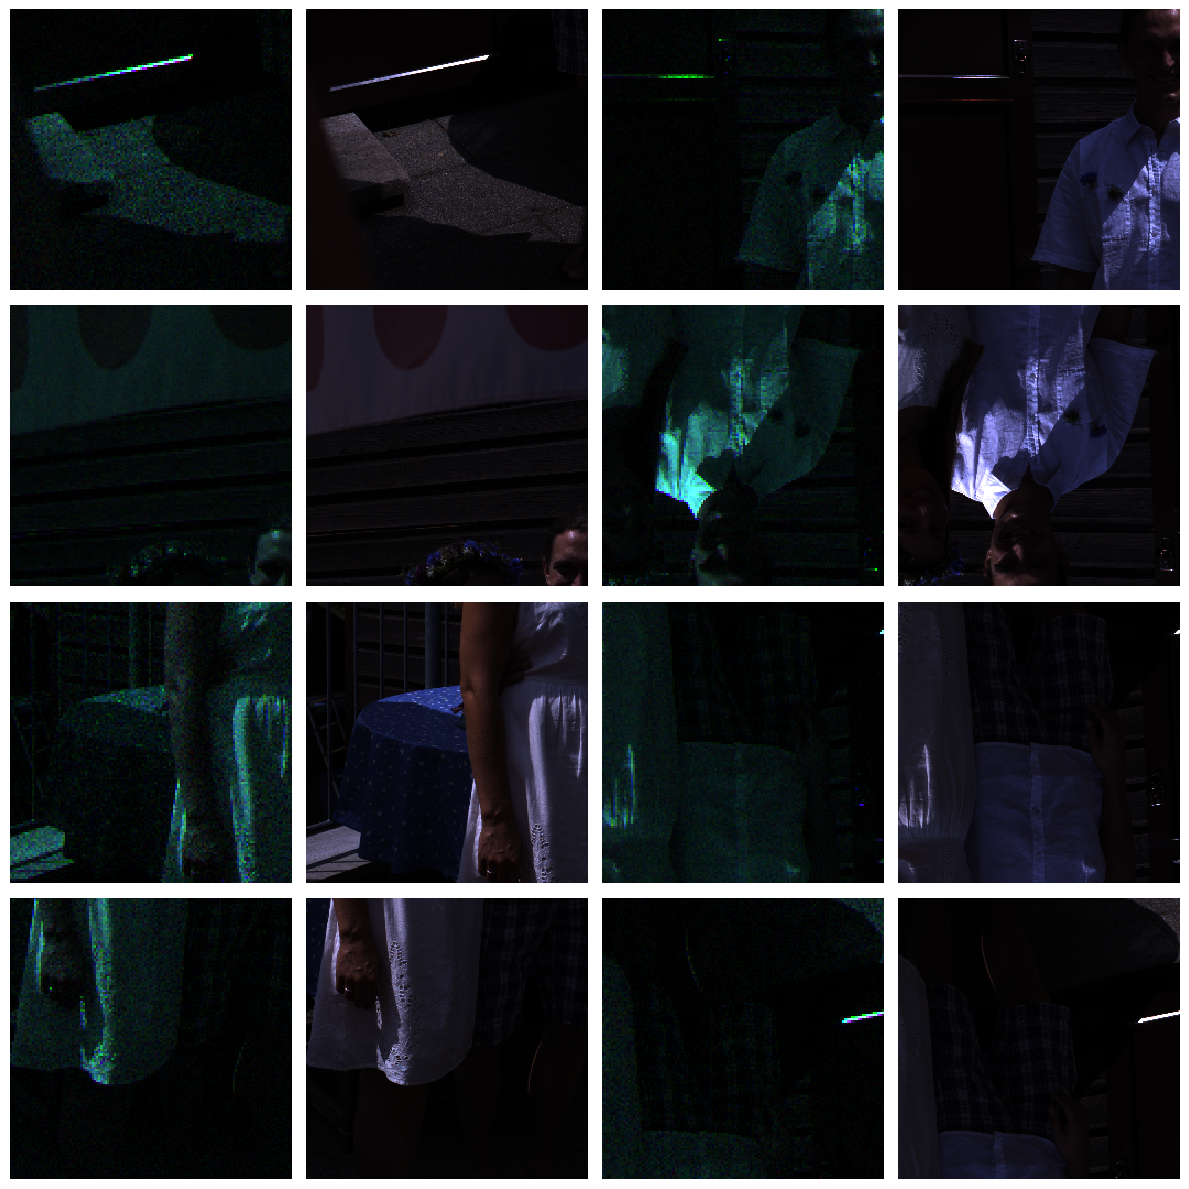

In [7]:
tiles_input = []
tiles_expected = []

for i in range(NUM_TRAINING_IMG):
    
    img_expected = images[i]
    n = TILES_PER_IMAGE
    ox = rng.integers(0, np.shape(img_expected)[1]-TILE_SIZE, n)
    oy = rng.integers(0, np.shape(img_expected)[0]-TILE_SIZE, n)
    flip = rng.integers(0, 4, n)
    # this scales with sensor data theoretically in native bit depth. i've only ever seen 14 bit raw, so let's scale to that
    scale = 16383.0 # really white - black but whatever
    noise_a = rng.exponential(noise_a_mean/scale/scale, n)
    noise_b = rng.exponential(noise_b_mean/scale, n)
    # it appears to be a good idea to inject no-noise every so often. the results come out much more excellent
    # when later choosing no noise a and b in the gui:
    # idx = rng.integers(0, n, n//100)
    # noise_a[idx] = np.zeros(n//100)
    # noise_b[idx] = np.zeros(n//100)

    tiles_input += generate_input_tiles(img_expected, n, ox, oy, flip, noise_a, noise_b)
    tiles_expected += generate_output_tiles(img_expected, n, ox, oy, flip)

display_tile_grid([tiles_input, tiles_expected], size=3)

In [8]:
# Validation
# TODO make sure this does *not* overlap with the training input..
validation_tiles_input = tiles_input[-10:]
validation_tiles_expected = tiles_expected[-10:]

## CNN

In [9]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # pm = 'reflect' # not implemented you suckers
        pm = 'zeros'
        self.enc0 = nn.Conv2d(INPUT_CHANNELS_COUNT, 32, 3, padding='same', padding_mode=pm)
        self.enc1 = nn.Conv2d(32, 43, 3, padding='same', padding_mode=pm)
        self.enc2 = nn.Conv2d(43, 57, 3, padding='same', padding_mode=pm)
        self.enc3 = nn.Conv2d(57, 76, 3, padding='same', padding_mode=pm)
        self.enc4 = nn.Conv2d(76, 101, 3, padding='same', padding_mode=pm)
        self.enc5 = nn.Conv2d(101, 101, 3, padding='same', padding_mode=pm)

        # self.extr = nn.Conv2d(32, 32, 3, padding='same', padding_mode=pm)
        
        self.dec0 = nn.Conv2d(101+101, 101, 3, padding='same', padding_mode=pm)
        self.con0 = nn.Conv2d(101, 101, 3, padding='same', padding_mode=pm)
        self.dec1 = nn.Conv2d(101+76, 76, 3, padding='same', padding_mode=pm)
        self.con1 = nn.Conv2d(76, 76, 3, padding='same', padding_mode=pm)
        self.dec2 = nn.Conv2d(76+57, 57, 3, padding='same', padding_mode=pm)
        self.con2 = nn.Conv2d(57, 57, 3, padding='same', padding_mode=pm)
        self.dec3 = nn.Conv2d(57+43, 43, 3, padding='same', padding_mode=pm)
        self.con3 = nn.Conv2d(43, 43, 3, padding='same', padding_mode=pm)
        self.dec4 = nn.Conv2d(43+32, 16, 3, padding='same', padding_mode=pm)
        self.con4 = nn.Conv2d(16, 16, 3, padding='same', padding_mode=pm)
        self.dec5 = nn.Conv2d(16+INPUT_CHANNELS_COUNT, 12, 3, padding='same', padding_mode=pm)
        self.con5 = nn.Conv2d(12, 12, 3, padding='same', padding_mode=pm)
        # self.dec5 = nn.Conv2d(12+32, 12, 3, padding='same', padding_mode=pm)

        # as much as i hate it, these extra convolutions seem to contribute quite a bit to image sharpness/overall fidelity.
        # potentially a more clever upsampling/convolution directly there would make the architecture more lightweight.
        
        
        
        # self.con0a = nn.Conv2d(101, 101, 3, padding='same', padding_mode=pm)
        # self.con1a = nn.Conv2d(76, 76, 3, padding='same', padding_mode=pm)
        # self.con2a = nn.Conv2d(57, 57, 3, padding='same', padding_mode=pm)
        # self.con3a = nn.Conv2d(43, 43, 3, padding='same', padding_mode=pm)
        # self.con4a = nn.Conv2d(16, 16, 3, padding='same', padding_mode=pm)
        # self.con5a = nn.Conv2d(12, 12, 3, padding='same', padding_mode=pm)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')

    def forward(self, I):
        extr = F.relu(self.enc0(I))
        # extr = F.relu(self.extr(extr))
        x_128 = self.pool(extr) # self.pool(F.relu(self.extr(extr)))
        # x_128 = self.pool(F.relu(self.enc0(I)))
        x_64  = self.pool(F.relu(self.enc1(x_128)))
        x_32  = self.pool(F.relu(self.enc2(x_64)))
        x_16  = self.pool(F.relu(self.enc3(x_32)))
        x_8   = self.pool(F.relu(self.enc4(x_16)))
        x_4   = self.pool(F.relu(self.enc5(x_8)))
        
        x     = F.relu(self.dec0(torch.cat([self.upsample(x_4), x_8],   1)))
        x     = F.relu(self.con0(x))
        # x     = F.relu(self.con0a(x))
        # x     = F.relu(self.dec1(torch.cat([self.upsample(x_8), x_16],  1)))
        x     = F.relu(self.dec1(torch.cat([self.upsample(x),   x_16],  1)))
        x     = F.relu(self.con1(x))
        # x     = F.relu(self.con1a(x))
        x     = F.relu(self.dec2(torch.cat([self.upsample(x),   x_32],  1)))
        x     = F.relu(self.con2(x))
        # x     = F.relu(self.con2a(x))
        x     = F.relu(self.dec3(torch.cat([self.upsample(x),   x_64],  1)))
        x     = F.relu(self.con3(x))
        # x     = F.relu(self.con3a(x))
        x     = F.relu(self.dec4(torch.cat([self.upsample(x),   x_128], 1)))
        # x     = F.relu(self.dec5(torch.cat([self.upsample(x),   extr],  1)))
        x     = F.relu(self.con4(x))
        # x     = F.relu(self.con4a(x))
        x     = F.relu(self.dec5(torch.cat([self.upsample(x),   I],  1)))
        x     = F.relu(self.con5(x))
        # x     = F.relu(self.con5a(x))
        
        return x

model = Net()
model.compile()
training_loss = []

In [ ]:
# train the model. re-run this cell to train it some more.
import torch.optim as optim

cmat = torch.from_numpy(M.T).cuda() # transpose because we'll multiply it from the left

class LowFreqLoss(nn.Module):
    def __init__(self):
        super(LowFreqLoss, self).__init__()

    def forward(self, output, target):
        # average blocks of NCHW 4x4 HW colours by summing them:
        bs = 8
        o3 = torch.mean(torch.reshape(output, (batch_size, 3, TILE_SIZE//bs, bs, TILE_SIZE//bs, bs)), dim=(3,5), dtype=torch.float32)
        t3 = torch.mean(torch.reshape(target, (batch_size, 3, TILE_SIZE//bs, bs, TILE_SIZE//bs, bs)), dim=(3,5), dtype=torch.float32)
        return torch.mean(torch.reshape(torch.abs(o3 - t3), (batch_size * 3 * (TILE_SIZE//bs) * (TILE_SIZE//bs), 1)), 0) # rgb L1

# mean image colour loss: fight spectral bias by explicitly asking for the lowest possible frequency to match
class MICLoss(nn.Module):
    def __init__(self):
        super(MICLoss, self).__init__()

    def forward(self, output, target):
        # average colours by summing them:
        # the network outputs NCHW (i.e. channels first!)
        o3 = torch.mean(torch.reshape(output, (batch_size, 3, (TILE_SIZE)*(TILE_SIZE))), dim=2, dtype=torch.float32)
        t3 = torch.mean(torch.reshape(target, (batch_size, 3, (TILE_SIZE)*(TILE_SIZE))), dim=2, dtype=torch.float32)
        return torch.mean(torch.reshape(torch.abs(o3 - t3), (batch_size * 3, 1)), 0) # rgb L1

# weight_decay=0.0
# lr=0.001
# betas=(0.9, 0.999)
optimiser = optim.Adam(model.parameters(), lr=0.001)
criterion0 = torch.nn.L1Loss()
# criterion1 = LowFreqLoss()
criterion1 = MICLoss()
# criterion0 = torch.nn.MSELoss() # explodes directly and then diverges
# criterion0 = torch.nn.HuberLoss(delta=0.5) # does not do anything
# criterion2 = piq.HaarPSILoss(data_range=2.0) # these are super stubborn with ranges and choke on nan
criterion2 = LowFreqLoss()
# criterion1 = piq.DSSLoss() # apparently only single channel
# criterion0 = piq.MultiScaleGMSDLoss()

for epoch in range(EPOCHS_COUNT):
    running_loss = 0.0
    for i in range((len(tiles_input)+batch_size-1)//batch_size):
        # inputs  = torch.clamp(torch.cat(tiles_input[batch_size*i:batch_size*(i+1)]), min=0.0, max=2.0).cuda()
        # targets = torch.clamp(torch.cat(tiles_expected[batch_size*i:batch_size*(i+1)]), min=0.0, max=2.0).cuda()
        inputs  = torch.cat(tiles_input[batch_size*i:batch_size*(i+1)]).cuda()
        targets = torch.cat(tiles_expected[batch_size*i:batch_size*(i+1)]).cuda()

        # zero the parameter gradients
        optimiser.zero_grad()
        
        # forward + backward + optimise
        with torch.autocast(device_type=device, dtype=torch.float16):
            outputs = model(inputs)
            loss = criterion0(outputs, targets)
            +      criterion1(outputs, targets)
            +      criterion2(outputs, targets)
            # needs clamping above, but seems to do nothing indeed:
            # + 100.*criterion2(torch.reshape(outputs, (batch_size, 3, TILE_SIZE, TILE_SIZE)),
            #                   torch.reshape(targets, (batch_size, 3, TILE_SIZE, TILE_SIZE)))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimiser.step()

        running_loss += loss.item()

    print(f'[{epoch + 1}] loss: {running_loss:.3f}')
    training_loss.append(running_loss)

print('finished training')

[1] loss: 5.870
[2] loss: 4.100
[3] loss: 3.849
[4] loss: 3.584
[5] loss: 3.359
[6] loss: 3.270
[7] loss: 3.142
[8] loss: 3.062
[9] loss: 3.031
[10] loss: 2.970
[11] loss: 2.998
[12] loss: 2.929
[13] loss: 2.897
[14] loss: 2.867
[15] loss: 2.837
[16] loss: 2.824
[17] loss: 2.808
[18] loss: 2.773
[19] loss: 2.745
[20] loss: 2.751
[21] loss: 2.884
[22] loss: 2.819
[23] loss: 2.765
[24] loss: 2.738
[25] loss: 2.716
[26] loss: 2.700
[27] loss: 2.692
[28] loss: 2.688
[29] loss: 2.787
[30] loss: 2.718
[31] loss: 2.746
[32] loss: 2.934
[33] loss: 2.956
[34] loss: 2.878
[35] loss: 2.944
[36] loss: 2.897
[37] loss: 2.906
[38] loss: 2.894
[39] loss: 2.859
[40] loss: 2.853
[41] loss: 2.827
[42] loss: 2.824
[43] loss: 2.806
[44] loss: 2.811
[45] loss: 2.792
[46] loss: 2.790
[47] loss: 2.787
[48] loss: 2.780
[49] loss: 2.783
[50] loss: 2.771
[51] loss: 2.768
[52] loss: 2.769
[53] loss: 2.760
[54] loss: 2.758
[55] loss: 2.754
[56] loss: 2.752
[57] loss: 2.747
[58] loss: 2.745
[59] loss: 2.741
[60] l

In [ ]:
# write raw f16 coefficients of the model into a file.
# probably in the future also write some information about training data/loss/network configuration? like a hash?
with open(MODEL_NAME+'.dat', 'wb') as f:
    for param in model.parameters():
        p = param.data.detach().cpu().numpy().astype('float16')
        # print(type(param), param.size())
        print(np.shape(p))
        f.write(p.tobytes())

In [ ]:
xs = range(10, len(training_loss))
plt.plot(xs, training_loss[10:], label = 'training loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()

In [ ]:
# import gc
# del model
# gc.collect()
# torch.cuda.empty_cache()

# make predictions on the training data
offset=1300
predictions = [model(tiles_input[offset+i].cuda()) for i in range(8)]
display_tile_grid([tiles_input[offset:], predictions, tiles_expected[offset:]], size=3)

# offset=10000 # some crazy aliasing
offset=2000
predictions = [model(tiles_input[offset+i].cuda()) for i in range(8)]
display_tile_grid([tiles_input[offset:], predictions, tiles_expected[offset:]], size=3)

offset=3000
predictions = [model(tiles_input[offset+i].cuda()) for i in range(8)]
display_tile_grid([tiles_input[offset:], predictions, tiles_expected[offset:]], size=3)

## Evaluation

In [ ]:
# TODO validation data

# Make predictions on the evaluation data
# test_predictions = tf.convert_to_tensor(model.predict(validation_tiles_input))
# display_tile_grid([validation_tiles_input, test_predictions, validation_tiles_expected], lines_count=4, size=3)